[( 2, 30,    463, 1) ( 9, 25,   3443, 1) ( 5,  0,   3853, 1) ...
 (18, 30, 302528, 1) (12,  6, 302796, 1) (18, 30, 303611, 1)]


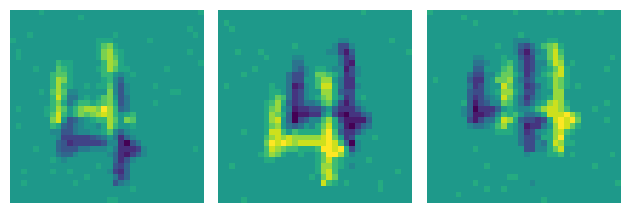

In [69]:
# pip install tonic
# pip install snntorch


#  Using Tonic to Load Neuromorphic Datasets

import tonic
import random

dataset = tonic.datasets.NMNIST(save_to='./data', train=True)
rand_ind = random.randint(0, len(dataset) - 1)
events, target = dataset[rand_ind]



# Each row corresponds to a single event, which consists of four parameters: (x-coordinate, y-coordinate, timestamp, polarity).
print(events)


tonic.utils.plot_event_grid(events)



In [1]:
# However, neural nets don’t take lists of events as input. 
# The raw data must be converted into a suitable representation, such as a tensor. 
# We can choose a set of transforms to apply to our data before feeding it to our network. 
# The neuromorphic camera sensor has a temporal resolution of microseconds, which when converted into a dense representation, 
# ends up as a very large tensor. 
# That is why we bin events into a smaller number of frames using the ToFrame transformation, 
# which reduces temporal precision but also allows us to work with it in a dense format.


import tonic.transforms as transforms
import tonic

sensor_size = tonic.datasets.NMNIST.sensor_size

# Denoise removes isolated, one-off events
# time_window
frame_transform = transforms.Compose([transforms.Denoise(filter_time=10000),
                                      transforms.ToFrame(sensor_size=sensor_size,
                                                         time_window=1000)
                                     ])

trainset = tonic.datasets.NMNIST(save_to='./data', transform=frame_transform, train=True)
testset = tonic.datasets.NMNIST(save_to='./data', transform=frame_transform, train=False)



from torch.utils.data import DataLoader
from tonic import DiskCachedDataset

cached_trainset = DiskCachedDataset(trainset, cache_path='./cache/nmnist/train')
cached_dataloader = DataLoader(cached_trainset)

# even faster (more RAM required)
# from tonic import MemoryCachedDataset

# cached_trainset = MemoryCachedDataset(trainset)


batch_size = 128
trainloader = DataLoader(cached_trainset, batch_size=batch_size, collate_fn=tonic.collation.PadTensors())

def load_sample_batched():
    events, target = next(iter(cached_dataloader))
    
    

    
%timeit -o -r 10 load_sample_batched()


4.72 ms ± 533 µs per loop (mean ± std. dev. of 10 runs, 100 loops each)


<TimeitResult : 4.72 ms ± 533 µs per loop (mean ± std. dev. of 10 runs, 100 loops each)>

Loading and preprocessing training data...


100%|██████████| 1/1 [00:48<00:00, 48.52s/it]



Done with preprocessing!
preparing data loaders with batch size 256
length of training data: 6269


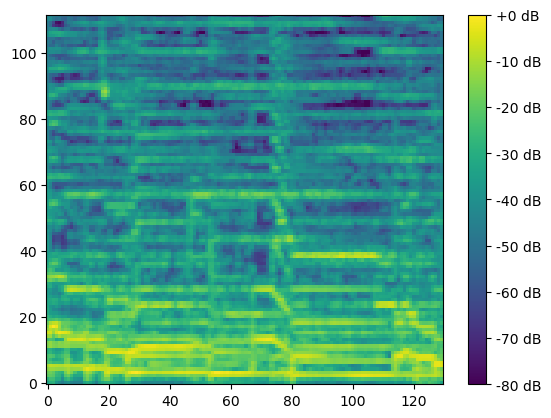

sum of dataset: 24
groundtruth:  96
bpm_librosa:  184.57031
genre:  7
input shape: (112, 130)


In [9]:
import audio_import as ai
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
from brian2 import *
from multiprocessing import Pool, cpu_count
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor
import pickle
from concurrent.futures import ProcessPoolExecutor
from sklearn.utils import shuffle
import random
import snntorch as snn
import torch
import re


batch_size = 256
files_to_load = 1000
SR = int(22050/2)

train_loader, val_loader, input_shape = ai.import_audio_get_loader(batch_size=batch_size, 
                                                             only_dataset=False, 
                                                             train_data_ratio=0.9, 
                                                             files_to_load=files_to_load,
                                                             sr=SR,
                                                             )

example_batch = next(iter(train_loader))
mel, groundtruth, librosa_bpm, genre = example_batch

single_mel = mel[0].squeeze(0)  # select the first mel-spec from the batch and remove the channel dimension

# librosa.display.specshow(librosa.power_to_db(data, ref=np.max), y_axis='mel', x_axis='time')
plt.imshow(librosa.power_to_db(single_mel, ref=np.max), origin='lower', aspect='auto')
plt.colorbar(format='%+2.0f dB')
plt.show()



print(f"sum of dataset: {len(train_loader) +len(val_loader)}")
print("groundtruth: ", groundtruth[0].cpu().numpy())
print("bpm_librosa: ", librosa_bpm[0].cpu().numpy())
print("genre: ", genre[0].cpu().numpy())
print(f"input shape: {input_shape}")



In [ ]:
# training a network on the N-MNIST classification task

# Now let’s actually train a network on the N-MNIST classification task. 
# We start by defining our caching wrappers and dataloaders. 
# While doing that, we’re also going to apply some augmentations to the training data. 
# The samples we receive from the cached dataset are frames, 
# so we can make use of PyTorch Vision to apply whatever random transform we would like.


import torch
import torchvision

transform = tonic.transforms.Compose([torch.from_numpy,
                                      torchvision.transforms.RandomRotation([-10,10])])

cached_trainset = DiskCachedDataset(trainset, transform=transform, cache_path='./cache/nmnist/train')

# no augmentations for the testset
cached_testset = DiskCachedDataset(testset, cache_path='./cache/nmnist/test')

batch_size = 128
trainloader = DataLoader(cached_trainset, batch_size=batch_size, collate_fn=tonic.collation.PadTensors(batch_first=False), shuffle=True)
testloader = DataLoader(cached_testset, batch_size=batch_size, collate_fn=tonic.collation.PadTensors(batch_first=False), shuffle=True)

# A mini-batch now has the dimensions (time steps, batch size, channels, height, width). 
# The number of time steps will be set to that of the longest recording in the mini-batch, 
# and all other samples will be padded with zeros to match it.

event_tensor, target = next(iter(trainloader))

print(event_tensor.shape)

In [ ]:


# class SpikingNN(nn.Module):
#     def __init__(self, beta=0.5):
#         super(SpikingNN, self).__init__()
        
#         # neuron and simulation parameters
#         spike_grad = surrogate.atan()

#         # Using nn.Sequential for Convolution and pooling parts
#         self.conv_seq = nn.Sequential(
#             nn.Conv2d(1, 12, (5, 1)),
#             nn.MaxPool2d((2, 1)),
#             snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),
#             nn.Conv2d(12, 32, (5, 1)),
#             nn.MaxPool2d((2, 1)),
#             snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True)
#         )

#         # # Recurrent layer
#         # self.rnn = nn.LSTM(800, 128, 2, batch_first=True)
        
#         # Output layer
#         self.fc1 = nn.Linear(128, 280)
#         self.lif_out = snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True, output=True)

#     def forward(self, x):
#         # Initialization
#         utils.reset(self.conv_seq[2])  # resets hidden states for the first LIF neuron
#         utils.reset(self.conv_seq[5])  # resets hidden states for the second LIF neuron
#         utils.reset(self.lif_out)  # resets hidden states for the output LIF neuron
        
#         batch_size, _, _, time_steps = x.size()
#         # print time_steps
#         print(f" time_steps: {time_steps}")
#         print(f" batch_size: {batch_size}")
        
#         spk_rec = []

#         num_layers = 1  # Assuming you have a single layer LSTM
#         num_directions = 2 if self.rnn.bidirectional else 2  # Check if your LSTM is bidirectional
#         hidden_size = self.rnn.hidden_size

#         h0 = torch.zeros(num_layers * num_directions, batch_size, hidden_size).to(x.device)
#         c0 = torch.zeros(num_layers * num_directions, batch_size, hidden_size).to(x.device)

#         for step in range(time_steps):
#             inp = x[:, :, :, step].unsqueeze(-1)  # Extract current time slice; ensure it has shape [batch, channels, height, 1]

#             # Apply conv layers
#             conv_out = self.conv_seq(inp)
#             conv_out = conv_out.view(batch_size, -1).unsqueeze(1)  # Flatten for RNN and keep time dimension

#             # Apply recurrent layers
#             rnn_out, (h0, c0) = self.rnn(conv_out, (h0, c0))

#             # Process through output layer
#             fc_out = self.fc1(rnn_out.squeeze(1))
#             lif_out, _ = self.lif_out(fc_out)

#             spk_rec.append(lif_out)

#         return torch.stack(spk_rec, dim=0)  # stack along time dimension




In [12]:
# Defining our network

# We will use snnTorch + PyTorch to construct a CSNN, just as in the previous tutorial. 
# The convolutional network architecture to be used is: 12C5-MP2-32C5-MP2-800FC10

# 12C5 is a 5x5 convolutional kernel with 12 filters

# MP2 is a 2x2 max-pooling function

# 800FC10 is a fully-connected layer that maps 800 neurons to 10 outputs

import snntorch as snn
from snntorch import surrogate
from snntorch import functional as SF
from snntorch import spikeplot as splt
from snntorch import utils
import torch.nn as nn
import torch

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# neuron and simulation parameters
spike_grad = surrogate.atan()
beta = 0.5

#  Initialize Network
# class SpikingNN(nn.Module):
#     def __init__(self, beta=0.5):
#         super(SpikingNN, self).__init__()
        
#         # neuron and simulation parameters
#         spike_grad = surrogate.atan()

#         # Convolution across frequency bands
#         self.conv1 = nn.Conv2d(1, 12, (5, 1))  # Convolve across frequency only
#         self.pool1 = nn.MaxPool2d((2, 1))
#         self.lif1 = snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True)
        
#         self.conv2 = nn.Conv2d(12, 32, (5, 1))
#         self.pool2 = nn.MaxPool2d((2, 1))
#         self.lif2 = snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True)

#         # Recurrent layer
#         # self.rnn = nn.LSTM(800, 128, 2, batch_first=True)
        
#         # Output layer
#         self.fc1 = nn.Linear(800, 260)
#         self.lif_out = snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True, output=True)

#     def forward(self, x):
#         batch_size, _, _, time_steps = x.size()
#         utils.reset(self.lif1)  # resets hidden states for the first LIF neuron
#         utils.reset(self.lif2)  # resets hidden states for the second LIF neuron    
#         utils.reset(self.lif_out)  # resets hidden states for the output LIF neuron
        
#         print(f" time_steps: {time_steps}")
#         print(f" batch_size: {batch_size}")

#         # Apply conv layers across all time steps
#         x = self.conv1(x)
#         x = self.pool1(x)
#         x = self.lif1(x)

#         x = self.conv2(x)
#         x = self.pool2(x)
#         x = self.lif2(x)
        
#         x = x.view(batch_size, time_steps, -1)  # Flatten for RNN
        
#         # Apply recurrent layers
#         # output, (h_n, c_n) = self.rnn(x)
#         x = x[:, -1, :]
        
#         # Output layer
#         x = self.fc1(x)
#         x = self.lif_out(x)
        
#         return x 
class SpikingNN(nn.Module):
    def __init__(self, beta=0.5, input_height=100, input_width=100):
        super(SpikingNN, self).__init__()
        
        kernel_size = 5
        # self.num_classes = 260
        self.num_classes = 1
        
        # compute the height and width after conv and pool operations
        self.height_after_conv = (input_height - kernel_size + 1) // 2
        self.height_after_conv = (self.height_after_conv - kernel_size + 1) // 2
        
        self.width_after_conv = input_width  # because there's no change in width

        self.num_features = 32 * self.height_after_conv * self.width_after_conv

        
        # neuron and simulation parameters
        spike_grad = surrogate.atan()

        self.layers = nn.Sequential(
            nn.Conv2d(1, 32, (kernel_size, 1)),
            nn.MaxPool2d((2, 1)),
            snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),
            
            nn.Conv2d(32, 64, (kernel_size, 1)),
            nn.MaxPool2d((2, 1)),
            snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),

            nn.Flatten(),  # Flatten before FC layer
            nn.Linear(208000, self.num_classes),
         #   snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True, output=True)
        )

    def forward(self, x):
        # batch_size, _, _, time_steps = x.size()
        # utils.reset(self.lif1)  # resets hidden states for the first LIF neuron
        # utils.reset(self.lif2)  # resets hidden states for the second LIF neuron    
        # utils.reset(self.lif_out)  # resets hidden states for the output LIF neuron
        spk_rec = []
        utils.reset(self.layers)  # resets hidden states for all LIF neurons in net

        
        # print(f" time_steps: {time_steps}")
        # print(f" batch_size: {batch_size}")

        # Apply conv layers across all time steps
        
        # x = self.conv1(x)
        # x = self.pool1(x)
        # x = self.lif1(x)

        # x = self.conv2(x)
        # x = self.pool2(x)
        # x = self.lif2(x)
        
        # x = x.view(batch_size, time_steps, -1)  # Flatten for RNN
        
        # # Apply recurrent layers
        # # output, (h_n, c_n) = self.rnn(x)
        # x = x[:, -1, :]
        
        # # Output layer
        # x = self.fc1(x)
        # x = self.lif_out(x)
        
        # spk_out, _ = self.layers(x)
        # print(f"x shape {x.shape}")
        spk_out = self.layers(x)

            
        return spk_out

        
        #return spk_out 


# Cross Entropy Loss can be applied to the total spike count to maximize the number of spikes from the correct class.
# Another option from the snn.functional module is to specify the target number of spikes from correct and incorrect classes. 
# The approach below uses the Mean Square Error Spike Count Loss, 
# which aims to elicit spikes from the correct class 80% of the time, and 20% of the time from incorrect classes.
# Encouraging incorrect neurons to fire could be motivated to avoid dead neurons.

example_batch = next(iter(train_loader))
mel, groundtruth, librosa_bpm, genre = example_batch
single_mel = mel[0].squeeze(0)

print(f"single_mel shape: {single_mel.shape}")

H, W = single_mel.shape

net = SpikingNN(input_height=H, input_width=W).to(device)

optimizer = torch.optim.Adam(net.parameters(), lr=2e-2, betas=(0.9, 0.999))
# optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
# loss_fn = SF.mse_count_loss(correct_rate=0.8, incorrect_rate=0.2)
loss_fn = torch.nn.MSELoss()

loss_hist = []
acc_hist = []
rmse_hist = []
mae_hist = []

single_mel shape: torch.Size([112, 130])


In [13]:
# training loop
from IPython.display import clear_output

num_iters = 100
num_epochs = 100

for epoch in range(num_epochs):
    for i, (data, targets, _, _) in enumerate(iter(train_loader)):

        clear_output(wait=True)  # This will clear the output of the cell where the function is called
        # print(data.shape)
        data = data.to(device)
        targets = targets.to(device)

        # print(f"Targets shape: {targets.shape}")

        net.train()
        # print(f"Data shape: {data.shape}")
        # # data = data.permute(3, 0, 1, 2)
        # print(f"Data shape: {data.shape}")

        spk_rec = net.forward(data)
        
        # spk_rec shape: torch.Size([310, 128, 10])
        # targets shape: torch.Size([128])

        # print(f"spike rec : {spk_rec.shape}")
        
        # # num_classes = 260
        # # print(f"targets_onehot shape: {targets_onehot.shape}")
        # print(f"targets shape : {targets.shape}")

        # for i, target in enumerate(targets):
        #   print(target, end="\n")
        #   if i == 10:
        #     break
        
        # # print len of targets
        # print(f"len of targets: {len(targets)}")
      
        # print(f"spk_rec shape: {spk_rec.shape}")
        # spk_rec = spk_rec.permute(1, 0, 2)
        # print(f"spk_rec shape: {spk_rec.shape}")
        # print(f"targets shape: {targets.shape}")
        loss_val = loss_fn(spk_rec, targets.float())

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        # acc = SF.accuracy_rate(spk_rec.unsqueeze(0), targets.float())
        # acc_hist.append(acc)
        # mae = torch.mean(torch.abs(spk_rec - targets.float()))
        # rmse = torch.sqrt(torch.mean((spk_rec - targets.float())**2))
        # mae_hist.append(mae)
        # rmse_hist.append(rmse)
        
        # print(f"Epoch {epoch}, Iteration {i} \nTrain Loss: {loss_val.item():.2f}, Accuracy: {acc * 100:.2f}%\n", end="\r\r\r")
        # print(f"Epoch {epoch}, Iteration {i} \nTrain Loss: {loss_val.item():.2f}, MAE: {mae:.2f}, RMSE: {rmse:.2f} \n", end="\r")
        print(f"Epoch {epoch}, Iteration {i} \nTrain Loss: {loss_val.item():.2f}")

        # training loop breaks after num_iters iterations
        # if i == num_iters:
        #   break
      


KeyboardInterrupt: 

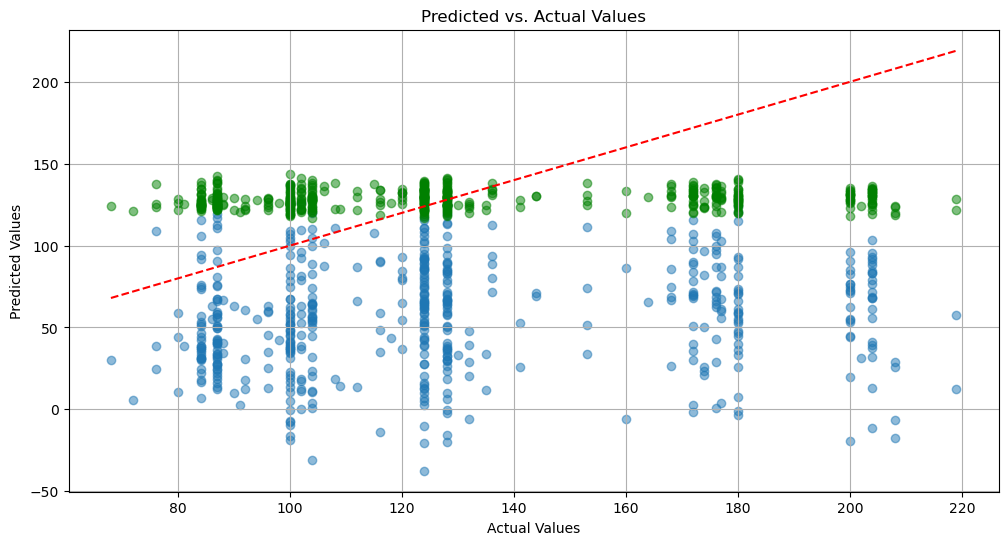

ValueError: x and y must be the same size

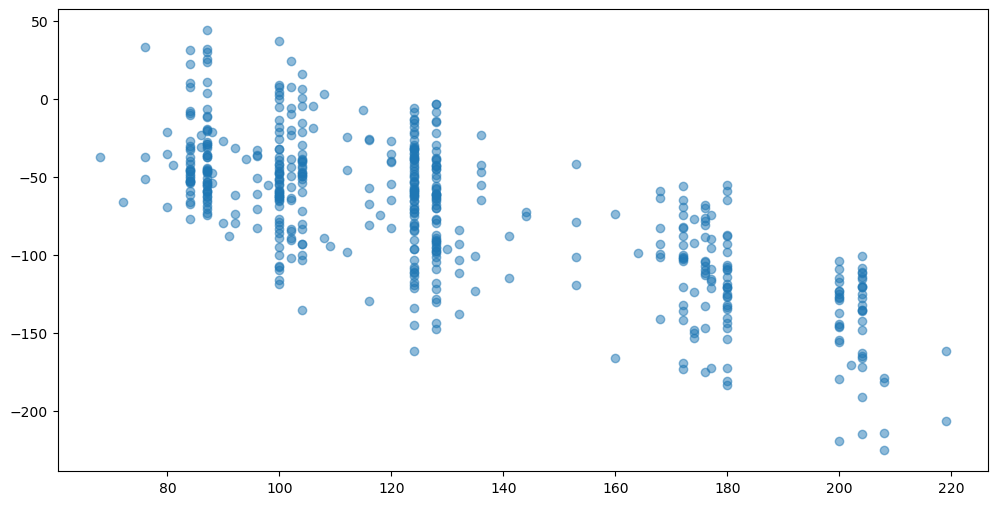

In [16]:
net.eval()  # Set the network in evaluation mode

predictions = []
actuals = []


with torch.no_grad():
    for data, targets, _, _ in val_loader:
        data = data.to(device)
        targets = targets.to(device)

        spk_rec = net(data)
        predictions.extend(spk_rec.cpu().numpy())
        actuals.extend(targets.cpu().numpy())


import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.scatter(actuals, predictions, alpha=0.5)
plt.plot([min(actuals), max(actuals)], [min(actuals), max(actuals)], color="red", linestyle="--")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs. Actual Values")
plt.grid(True)
plt.show()

residuals = [pred - actual for pred, actual in zip(predictions, actuals)]

plt.figure(figsize=(12, 6))
plt.scatter(actuals, residuals, alpha=0.5)
plt.axhline(y=0, color="red", linestyle="--")
plt.xlabel("Actual Values")
plt.ylabel("Residuals (Predicted - Actual)")
plt.title("residuals")
plt.show()


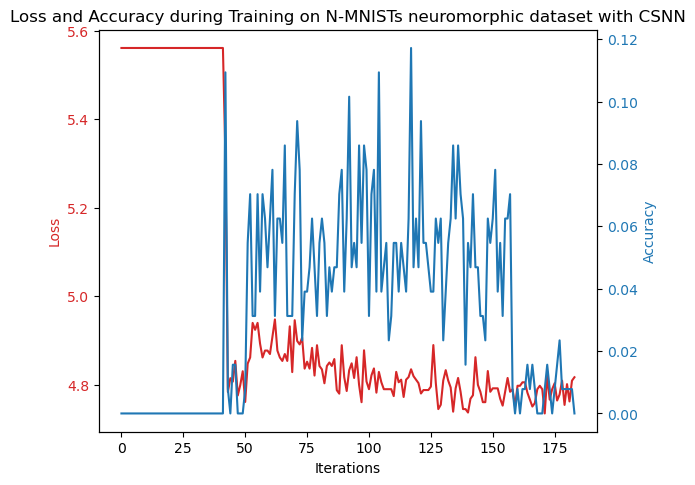

In [49]:
# plot loss and acc

import matplotlib.pyplot as plt

# Create a figure and a set of subplots
fig, ax1 = plt.subplots()

# Make the first plot: Loss values
color = 'tab:red'
ax1.set_xlabel('Iterations')
ax1.set_ylabel('Loss', color=color)
ax1.plot(loss_hist, color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis that shares the same x-axis
ax2 = ax1.twinx()  

# Make the second plot: Accuracy values
color = 'tab:blue'
ax2.set_ylabel('Accuracy', color=color)  # we already handled the x-label with ax1
ax2.plot(acc_hist, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # To make sure that the right y-label is not slightly clipped
plt.title('Loss and Accuracy during Training on N-MNISTs neuromorphic dataset with CSNN')
plt.show()

In [56]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Initialize lists to store true labels and predictions
true_labels = []
predicted_labels = []

# Variables to store cumulative loss and correct predictions
cumulative_loss = 0.0
correct_predictions = 0
total_samples = 0

# Set the network to evaluation mode
net.eval()

# Set number of batches to evaluate on
num_batches_to_evaluate = 50  # You can adjust this number based on your needs

# Loop through the test data
for batch_idx, (data, targets, _, _) in enumerate(val_loader):
    if batch_idx >= num_batches_to_evaluate:
        break
    data = data.to(device)
    targets = targets.to(device)

    with torch.no_grad():
        spk_rec = net.forward(data)
        loss_val = loss_fn_new(spk_rec, targets)
        cumulative_loss += loss_val.item() * data.size(0)  # Multiply by batch size to get total loss for this batch
    
    
    # Sum spikes over time and obtain class predictions
    summed_spikes = spk_rec.sum(dim=0)  # Summing over the time dimension
    
    # Get predicted classes
    predictions = torch.argmax(summed_spikes, dim=1)

    # Calculate the accuracy using SF.accuracy_rate and update the number of correct predictions
    acc = SF.accuracy_rate(spk_rec, targets)
    correct_predictions += acc * data.size(0)  # This assumes accuracy_rate returns a value between 0 and 1

    true_labels.extend(targets.cpu().numpy())
    predicted_labels.extend(predictions.cpu().numpy())
    total_samples += data.size(0)
    print(f"Batch {batch_idx+1}/{num_batches_to_evaluate}", end='\r')

# Calculate overall accuracy and loss
overall_accuracy = 100 * correct_predictions / total_samples
average_loss = cumulative_loss / total_samples

overall_accuracy = f"Overall Accuracy: {overall_accuracy:.2f}%"
overall_loss = f"Overall Loss: {average_loss:.4f}"
print(overall_accuracy)
print(overall_loss)

# Calculate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay(cm, display_labels=range(cm.shape[0])).plot(ax=ax, cmap=plt.cm.Blues, values_format='d')
ax.set_title(f'Confusion matrix of CSNN on N-MNISTs neuromorphic dataset\n{overall_accuracy}\n{overall_loss}')
plt.tight_layout()
plt.show()



IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 2)

The target label is: 9


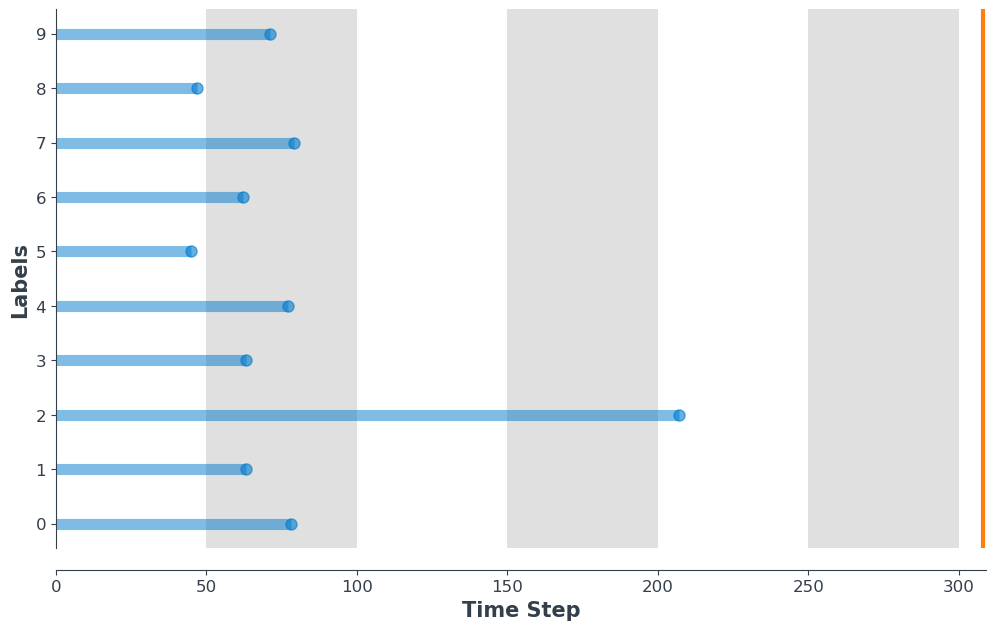

In [38]:
from IPython.display import HTML

idx = 0

fig, ax = plt.subplots(facecolor='w', figsize=(12, 7))
labels=['0', '1', '2', '3', '4', '5', '6', '7', '8','9']
print(f"The target label is: {targets[idx]}")

#plt.rcParams['animation.ffmpeg_path'] = 'C:\\path\\to\\your\\ffmpeg.exe'

#  Plot spike count histogram
anim = splt.spike_count(spk_rec[:, idx].detach().cpu(), fig, ax, labels=labels,
                        animate=True, interpolate=1)

HTML(anim.to_html5_video())

In [78]:
# Save the model parameters (weights)
torch.save(net.state_dict(), 'neuro_csnn2.pth')

In [81]:
# First, initialize the model architecture
net = SpikingNN()
net.load_state_dict(torch.load('neuro_csnn2.pth'))
# If using CUDA
net.to(device)

net.eval()




SpikingNN(
  (layers): Sequential(
    (0): Conv2d(2, 12, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Leaky()
    (3): Conv2d(12, 32, kernel_size=(5, 5), stride=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Leaky()
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=800, out_features=10, bias=True)
    (8): Leaky()
  )
)

: 